# Imports

In [6]:
import numpy as np
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import SGD
from torch.nn import Linear, Sigmoid, ReLU, Module, MSELoss, ModuleList, Sequential, BatchNorm1d
from torch.nn.init import xavier_uniform_ 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Dataset Importer

In [7]:
class CSV_Importer(Dataset):
    #loader
    def __init__(self, path):
        #use pandas to load the csv file
        df = read_csv(path, header=None)
        #split the features and lables
        self.X = df.values[:, :-1].astype('float32')
        self.y = df.values[:, -1].astype('float32')
        self.y = self.y.reshape((len(self.y), 1))

    #returns the number of rows
    def __len__(self):
        return len(self.X)

    #returns a given row
    def __getitem__(self, i):
        return [self.X[i], self.y[i]]

    #splits train and test data
    def get_splits(self, test_size=0.3):
        test = round(test_size * len(self.X))
        train = len(self.X) - test
        return random_split(self, [train, test])

# MLP definition

In [8]:
class MLP(Module):
    #initialize model
    def __init__(self, n_inputs, layer_sizes, n_outputs):
        super(MLP, self).__init__()
        #Build the model
        self.layers = []
        layer = Linear(n_inputs, layer_sizes[0])
        xavier_uniform_(layer.weight)
        bn = BatchNorm1d(num_features=layer_sizes[0])
        self.layers.extend([layer, bn, ReLU()])
        for i in range(len(layer_sizes) - 1):
            layer = Linear(layer_sizes[i], layer_sizes[i+1])
            xavier_uniform_(layer.weight)
            bn = BatchNorm1d(num_features=layer_sizes[i+1])
            self.layers.extend([layer, bn, ReLU()])
        layer = Linear(layer_sizes[-1], n_outputs)
        xavier_uniform_(layer.weight)
        self.layers.append(layer)
        self.layers = Sequential(*self.layers)

    #forward pass
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    

## Trainer Class

In [9]:
class Trainer(object):
    def __init__(self, path, model, batch_train=64, batch_test=512):
        #load data
        self.dataset = CSV_Importer(path)
        #split data
        train, test = self.dataset.get_splits(test_size=0.33)
        self.train_dl = DataLoader(train, batch_size=batch_train, shuffle=True)
        self.test_dl = DataLoader(test, batch_size=batch_test, shuffle=False)
        #save the model
        self.model = model
        self.batch_train = batch_train

    def train(self, epochs):
        self.model.train()
        #set loss and optimizer
        criterion = MSELoss()
        optimizer = SGD(self.model.parameters(), lr=1e-5, momentum=0.9)
        #train
        losses = []
        for epoch in tqdm(range(epochs), desc='Epochs'):
            #batches
            running_loss = 0.0
            for i, data in enumerate(self.train_dl):
                inputs, labels = data
                #initialize the gradients
                optimizer.zero_grad()
                #predict the output
                y = self.model(inputs)
                #calculate loss
                loss = criterion(y, labels)
                #backprop
                loss.backward()
                #update weights
                optimizer.step()

                running_loss += loss.item()
            #print loss every epoch
            tqdm.write("[%d] loss: %.4f" % (epoch + 1, running_loss / self.batch_train))
            losses.append(running_loss / self.batch_train)
        
        plt.figure()
        plt.plot(losses)
        
    
    def evaluate(self):
        predictions, true_labels = list(), list()
        for i, (inputs, labels) in enumerate(self.test_dl):
            #predict output
            y = self.model(inputs)
            y = y.detach().numpy()
            #get labels
            true_label = labels.numpy()
            true_label = true_label.reshape((len(true_label), 1))
            #save
            predictions.append(y)
            true_labels.append(true_label)
        predictions, true_labels = np.vstack(predictions), np.vstack(true_labels)
        #calculate loss
        mse = mean_squared_error(true_labels, predictions)
        return mse

    def predict(self, x):
        #create tensor
        x = Tensor([x])
        #predict output
        self.model.eval()
        y = self.model(x)
        return y.detach().numpy()
        

In [10]:
path = "./data/boston_housing.csv"
model = MLP(13, [50, 50, 10], 1)
trainer = Trainer(path, model)
print(len(trainer.train_dl.dataset), len(trainer.test_dl.dataset))

339 167


[1] loss: 55.2229
[2] loss: 52.4611
[3] loss: 52.3792
[4] loss: 53.8211
[5] loss: 51.9499
[6] loss: 51.1992
[7] loss: 49.2642
[8] loss: 48.9639
[9] loss: 49.5458
[10] loss: 52.6123
[11] loss: 48.9628
[12] loss: 47.8827
[13] loss: 47.8508
[14] loss: 49.2598
[15] loss: 47.2007
[16] loss: 47.8127
[17] loss: 45.8699
[18] loss: 47.6787
[19] loss: 47.1878
[20] loss: 46.9647
[21] loss: 45.9483
[22] loss: 44.7670
[23] loss: 46.2131
[24] loss: 43.4912
[25] loss: 43.6907
[26] loss: 46.2011
[27] loss: 44.0309
[28] loss: 43.5952
[29] loss: 42.8137
[30] loss: 43.3569
[31] loss: 41.6522
[32] loss: 40.6117
[33] loss: 41.0659
[34] loss: 39.1346
[35] loss: 38.0748
[36] loss: 40.4337
[37] loss: 38.1391
[38] loss: 38.7496
[39] loss: 37.0462
[40] loss: 36.9986
[41] loss: 36.4784
[42] loss: 36.4222
[43] loss: 34.9517
[44] loss: 35.7488
[45] loss: 33.1455
[46] loss: 34.6107
[47] loss: 34.6340
[48] loss: 32.4031
[49] loss: 32.8602
[50] loss: 30.6598
[51] loss: 29.9351
[52] loss: 30.3762
[53] loss: 32.6746
[5

[437] loss: 1.0511
[438] loss: 1.3331
[439] loss: 0.9407
[440] loss: 1.0173
[441] loss: 1.0488
[442] loss: 1.2443
[443] loss: 1.2699
[444] loss: 1.0740
[445] loss: 1.3510
[446] loss: 0.9862
[447] loss: 1.4206
[448] loss: 0.9830
[449] loss: 1.0357
[450] loss: 1.2112
[451] loss: 1.5902
[452] loss: 1.1918
[453] loss: 1.1854
[454] loss: 0.9608
[455] loss: 1.0471
[456] loss: 1.1729
[457] loss: 1.7006
[458] loss: 1.2588
[459] loss: 1.2409
[460] loss: 1.2107
[461] loss: 1.0787
[462] loss: 1.4229
[463] loss: 1.1171
[464] loss: 0.9219
[465] loss: 1.0869
[466] loss: 1.3915
[467] loss: 1.0126
[468] loss: 1.4957
[469] loss: 1.9904
[470] loss: 1.3741
[471] loss: 1.4202
[472] loss: 1.1393
[473] loss: 1.2768
[474] loss: 1.3784
[475] loss: 1.4043
[476] loss: 1.1282
[477] loss: 1.1021
[478] loss: 1.4293
[479] loss: 1.5497
[480] loss: 1.1424
[481] loss: 1.3048
[482] loss: 1.0180
[483] loss: 1.4020
[484] loss: 2.1035
[485] loss: 1.3049
[486] loss: 1.2299
[487] loss: 1.2299
[488] loss: 1.0440
[489] loss: 

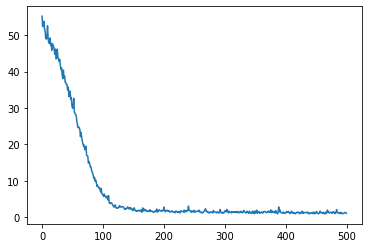

In [11]:
trainer.train(500)

In [7]:
mse = trainer.evaluate()
print('MSE: %.4f, RMSE: %.4f' % (mse, np.sqrt(mse)))
x = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
y = trainer.predict(x)

print("Predicted: %.4f" % y)

MSE: 19.9254, RMSE: 4.4638
Predicted: 35.1578
